# Notebook 04 – Neural Network Model

In [44]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

Load data

In [45]:
data = pd.read_csv(r"C:\Users\USER\PycharmProjects\ML\data\Telco-Customer-Churn.csv")
data.drop(columns=['customerID'], inplace=True)
data['Churn'] = data['Churn'].map({'Yes':1, 'No':0})
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

Preprocessing

In [46]:
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()
numerical_cols.remove('Churn')

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(drop='first'), categorical_cols)
])

X = data.drop('Churn', axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

X_train_pre = preprocessor.fit_transform(X_train)
X_test_pre = preprocessor.transform(X_test)

Handle imbalance

In [47]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_pre, y_train)

Build NN

In [48]:
def create_nn(hidden_units=16, dropout_rate=0.2):
    model = Sequential()
    model.add(Dense(hidden_units, activation='relu', input_dim=X_train_res.shape[1]))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

keras_clf = KerasClassifier(model=create_nn, hidden_units=16, dropout_rate=0.2, epochs=50, batch_size=32, verbose=0)

Hyperparameter tuning

In [49]:
param_dist = {
    'hidden_units':[16,32,64],
    'dropout_rate':[0.1,0.2,0.3],
    'epochs':[30,50],
    'batch_size':[16,32]
}

rs_nn = RandomizedSearchCV(keras_clf, param_distributions=param_dist, n_iter=4, cv=3, scoring='accuracy', random_state=42)
rs_nn.fit(X_train_res, y_train_res)

print("Best parameters:", rs_nn.best_params_)
print("Best CV accuracy:", rs_nn.best_score_)

Best parameters: {'hidden_units': 64, 'epochs': 50, 'dropout_rate': 0.3, 'batch_size': 32}
Best CV accuracy: 0.7004043858220702


Evaluation

Test accuracy: 0.759403832505323


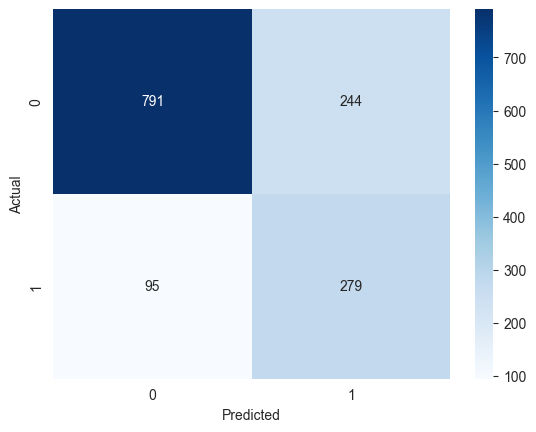

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1035
           1       0.53      0.75      0.62       374

    accuracy                           0.76      1409
   macro avg       0.71      0.76      0.72      1409
weighted avg       0.80      0.76      0.77      1409



In [50]:
y_pred = rs_nn.predict(X_test_pre)
print("Test accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()
print(classification_report(y_test, y_pred))